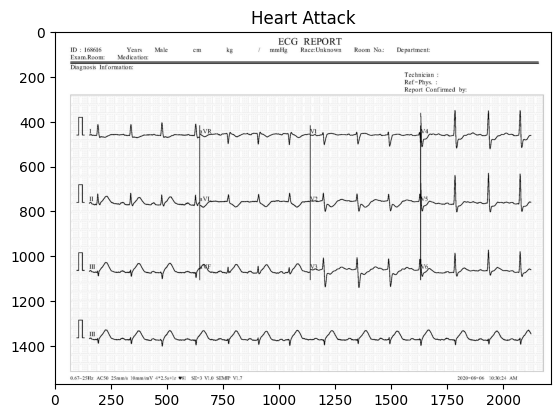

,image,label
0,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",Heart Attack
1,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",Heart Attack
2,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",Heart Attack
3,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",Heart Attack
4,"[[255, 255, 255, 255, 255, 255, 255, 255, 255,...",Heart Attack


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Path to the folder containing heart attack images
heart_attack_folder = '/content/drive/MyDrive/gwbz3fsgp8-2/ECG Images of Myocardial Infarction Patients (240x12=2880)'

# Path to the folder containing normal heartbeat images
normal_heartbeat_folder = '/content/drive/MyDrive/gwbz3fsgp8-2/Normal Person ECG Images (284x12=3408)'
abnormal_heartbeat_folder = '/content/drive/MyDrive/gwbz3fsgp8-2/ECG Images of Patient that have abnormal heartbeat (233x12=2796)'
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        # Read the image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # You can change color format if needed
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

# Load heart attack and normal images
heart_attack_images, heart_attack_labels = load_images_from_folder(heart_attack_folder, 'Heart Attack')
normal_heartbeat_images, normal_heartbeat_labels = load_images_from_folder(normal_heartbeat_folder, 'Normal')
abnormal_heartbeat_images, abnormal_heartbeat_labels = load_images_from_folder(abnormal_heartbeat_folder, 'Abnormal')

# Combine the two datasets
all_images = heart_attack_images + normal_heartbeat_images + abnormal_heartbeat_images
all_labels = heart_attack_labels + normal_heartbeat_labels + abnormal_heartbeat_labels

# Create a DataFrame with the image paths and labels
df = pd.DataFrame({'image': all_images, 'label': all_labels})

# Example of displaying the first image with its label
plt.imshow(df['image'][0], cmap='gray')
plt.title(df['label'][0])
plt.show()

# Check the DataFrame
df.head()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing and Transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1,1] for 1-channel grayscale
])

# Label encoding
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['encoded_label'])

# Custom Dataset
class ECGDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['encoded_label']

        if self.transform:
            image = self.transform(image)

        return image, label

# DataLoaders
batch_size = 32

train_dataset = ECGDataset(train_df, transform=transform)
test_dataset = ECGDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the ResNet + LSTM model
class ResNetLSTM(nn.Module):
    def __init__(self, hidden_size=128, num_classes=3):
        super(ResNetLSTM, self).__init__()

        # Load pre-trained ResNet18
        self.resnet = models.resnet18(pretrained=True)

        # Modify the first conv layer to accept 1 channel instead of 3
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the fully connected layer
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-2])

        # LSTM
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_size, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)

        # Pass through ResNet (output shape: batch_size, 512, 7, 7)
        x = self.resnet(x)

        # Flatten spatial dimensions (7x7) → treat as sequence
        x = x.view(batch_size, 49, 512)  # (batch_size, seq_len=49, feature_dim=512)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)

        # Take last output of LSTM
        out = lstm_out[:, -1, :]

        # Fully connected layer
        out = self.fc(out)
        return out

# Initialize model, loss, optimizer
model = ResNetLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

# Testing the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Test Accuracy of the model: {100 * correct / total:.2f}%')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


Epoch [1/10], Loss: 0.7205, Accuracy: 80.99%
Epoch [2/10], Loss: 0.1982, Accuracy: 99.50%
Epoch [3/10], Loss: 0.0608, Accuracy: 100.00%
Epoch [4/10], Loss: 0.0317, Accuracy: 100.00%
Epoch [5/10], Loss: 0.0197, Accuracy: 100.00%
Epoch [6/10], Loss: 0.0138, Accuracy: 100.00%
Epoch [7/10], Loss: 0.0103, Accuracy: 100.00%
Epoch [8/10], Loss: 0.0085, Accuracy: 100.00%
Epoch [9/10], Loss: 0.0070, Accuracy: 100.00%
Epoch [10/10], Loss: 0.0061, Accuracy: 100.00%
Test Accuracy of the model: 98.68%


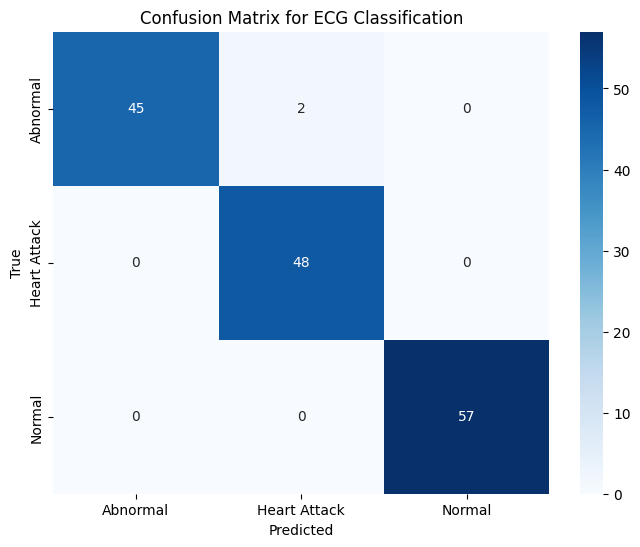

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Evaluate the model and get predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get predictions
        outputs = model(images)
        _, predicted = outputs.max(1)

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Get class names (labels)
class_names = label_encoder.classes_

# Plot the confusion matrix
plot_confusion_matrix(cm, class_names, title="Confusion Matrix for ECG Classification")
